# TD6: Solving the spherical laplacian using spectral methods
*Prepared by Bruno Régaldo-Saint Blancard*

The goal of this TD is to solve a **laplacian problem** in **spherical geometry** with Dirichlet boundary conditions using **spectral methods**. The spatial domain $\Omega$ of this problem is the spherical shell bounded by two concentric spheres $\mathcal{S}(0, R_1)$ (sphere of radius $R_1$ centered at the origin) and $\mathcal{S}(0, R_2)$ with $R_1 < R_2$. Thus we want to solve:
$$
   \begin{cases}
        \Delta f (r, \theta, \varphi) = 0 \text{ with } (r, \theta, \varphi) \in \Omega\\
        f (R_1, \theta, \varphi) = g_1 (\theta, \varphi) \\
        f (R_2, \theta, \varphi) = g_2 (\theta, \varphi)
   \end{cases}
$$
with $g_1$ and $g_2$ two boundary functions. To simplify this problem, we will assume **$\varphi$ invariance** so we can forget about this variable and we will use the following boundary functions:
$$
   \begin{cases}
        g_1 (\theta) = \cos (\theta)\\
        g_2 (\theta) = 0
   \end{cases}
$$

We will adopt the following convention to define spherical coordinates $(r, \theta, \varphi)$ in a cartesian system:
 <div class="row">
  <div class="column" style="float:left; margin:0; width:50%;">$$
\begin{align}&\\&\\ x&=r \, \sin\theta \, \cos\varphi \\ y&=r \, \sin\theta \, \sin\varphi \\ z&=r \, \cos\theta\end{align}
$$ </div>
  <div class="column" style="float:left; margin:0; width:50%;">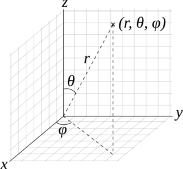</div>
</div> 

$(r, \theta, \varphi)$ variables should satisfy: $r \geq 0$, $\theta \in [0, \pi]$ and $\varphi \in [0, 2\pi[$.


We will need the usual Python packages:

In [1]:
# To draw matplotlib plots within this notebook.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Part 1: Spherical harmonics

[Spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics) are a set of angular functions which can be defined by:
$$
Y^m_l(\theta,\varphi) = \sqrt{\frac{2l+1}{4\pi} \frac{(l-m)!}{(l+m)!}}
  e^{i m \varphi} P^m_l(\cos(\theta))
$$
with $P_l^m$ an [associated Legendre polynomial](https://en.wikipedia.org/wiki/Associated_Legendre_polynomials). These functions are eigenfunctions of the angular laplacian operator $\Delta_{\text{ang}}$:
$$
    \Delta_{\text{ang}}Y^m_l = \left(\frac{\partial^2}{\partial \theta^2} + \frac1{\tan \theta}\frac{\partial}{\partial \theta}+\frac1{\sin^2\theta}\frac{\partial^2}{\partial\varphi^2}\right)Y_l^m = -l(l+1)Y_l^m
$$

In Python, we can manipulate these functions using [scipy.special.sph_harm](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.special.sph_harm.html) routine. We will be very careful to the fact that the documentation page of this routine uses another convention for the variables: $\theta$ and $\varphi$ variables are inverted.

**1)** Plot the real component of a few spherical harmonics in 2D using [pcolor](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolor.html) routine.

/home/bruno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


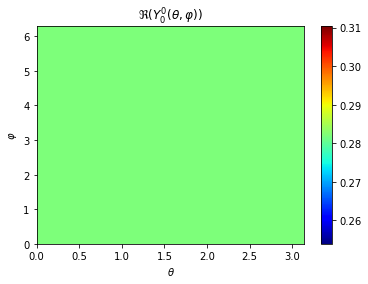

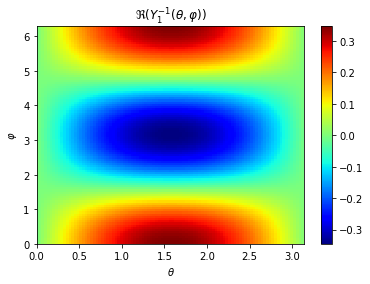

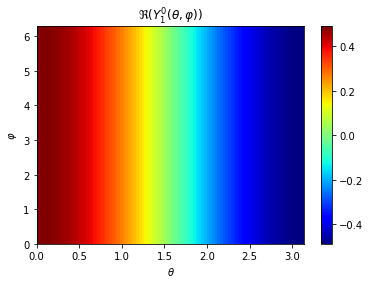

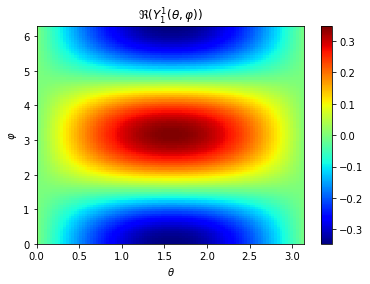

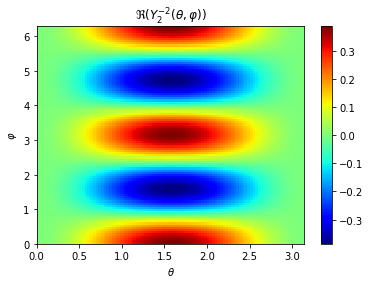

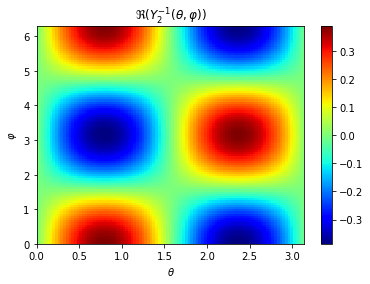

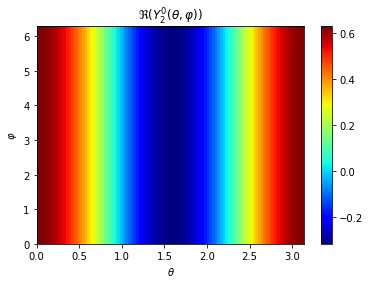

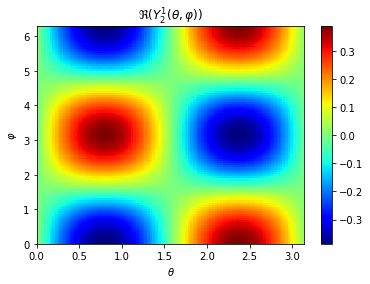

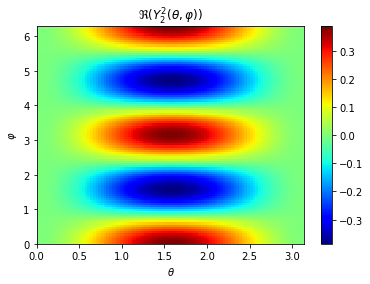

In [2]:
from scipy.special import sph_harm

theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
theta_grid, phi_grid = np.meshgrid(theta, phi)

for l in range(3):
    for m in range(-l, l + 1):
        plt.figure()
        # Becareful with pcolor function: ticks indicate bottom-left corners of grid cells
        plt.pcolor(theta_grid, phi_grid, sph_harm(m, l, phi_grid, theta_grid).real, cmap=plt.cm.jet)
        plt.colorbar()
        plt.xlabel(r'$\theta$')
        plt.ylabel(r'$\varphi$')
        plt.title(r"$\Re{(Y_" + str(l) + "^{" + str(m) + r"}(\theta, \varphi))}$")
        plt.show()

For information, we can also have a 3D view of these functions using the following routine:

In [3]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_sph(l, m, res=30):
    theta = np.linspace(0, np.pi, res)
    phi = np.linspace(0, 2 * np.pi, res)
    theta, phi = np.meshgrid(theta, phi)

    # The Cartesian coordinates of the unit sphere
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
    fcolors = sph_harm(m, l, phi, theta).real
    fmax, fmin = fcolors.max(), fcolors.min()
    fcolors = (fcolors - fmin) / (fmax - fmin)

    # Set the aspect ratio to 1 so our sphere looks spherical
    fig = plt.figure(figsize=plt.figaspect(1.))
    ax = fig.add_subplot(111, projection='3d')
    m = cm.ScalarMappable(cmap=cm.seismic)
    m.set_array(fcolors)
    ax.plot_surface(xTT, y, z, rstride=1, cstride=1, facecolors=cm.seismic(fcolors))
    ax.set_axis_off()
    plt.colorbar(m)
    plt.show()

Any square-integrable function $f(\theta, \phi)$ can be expanded as a linear combination of spherical harmonics:
$$
    f(\theta, \varphi) = \sum_{l=0}^\infty \sum_{m=-l}^l f_l^m \, Y_l^m(\theta, \varphi)
$$
The coefficients can be computed through the following relation:
$$
f_l^m=\int_{\Omega} f(\theta,\varphi)\, Y_l^{m*}(\theta,\varphi)\,d\Omega = \int_0^{2\pi}d\varphi\int_0^\pi \,d\theta\,\sin\theta~f(\theta,\varphi)~Y_l^{m*} (\theta,\varphi)
$$

**2)** Write a function which computes for a given function $f$ and given integers $l$ and $m$ the associated complex coefficient $f_l^m$. We can use the routine [scipy.integrate.dblquad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.dblquad.html#scipy.integrate.dblquad) to compute this double integral. It is recommended to have a look at the [scipy.integrate](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html) documentation page to see an example.

In [4]:
from scipy.integrate import dblquad


def ylm_projection(f, l, m):
    re_int = dblquad(lambda p, t: np.real(np.sin(t) * f(t, p) * np.conj(sph_harm(m, l, p, t))), 0, np.pi, lambda x: 0, lambda x: 2 * np.pi)
    im_int = dblquad(lambda p, t: np.imag(np.sin(t) * f(t, p) * np.conj(sph_harm(m, l, p, t))), 0, np.pi, lambda x: 0, lambda x: 2 * np.pi)
    return re_int[0] + 1j*im_int[0] # Return the value of the integral but discard the estimation of the error


# Testing cos (theta) projection
ylm_projection(lambda t, p: np.cos(t), 1, 0)

(2.046653415892977+0j)

## Part 2: A spectral approach

We want to solve the previous Laplacian equation using spectral methods. We will approximate the solution by an expansion over **Chebyshev polynomials for the radial variable $r$**, and over **spherical harmonics for the angular variable $\theta$**. Our numerical solution should take the following form:
$$
    f^{\text{appr}}(r, \theta) = \sum_{l=0}^L\sum_{n=0}^Nf_{l,n}T_n(u(r))Y_l^0(\theta) \text{ with } u(r) = \frac{r - (R_1+R_2)/2}{(R_2 - R_1)/2}
$$
$u$ function plays the role of a new variable satisfying $u \in [-1, 1]$.

To solve our problem, we will work in **spectral space**. Therefore, the goal is to **find $\{f_{l,n}\}_{0 \leq l \leq L, 0 \leq n \leq N}$ coefficients** so that $f^{\text{appr}}$ can  satisfy the problem equation as well as the boundary conditions in an ideal case. But as there is no reason for the exact solution of this problem to be of the prescribed form, we will eventually need to make reasonable compromises so that $f^{\text{appr}}$ verifies the boundary conditions.

Let us define $L$ and $N$ variables with Python with some intial values. We are strongly encouraged to change these values during this TD.

In [2]:
N = 20
L = 20

**3)** We recall the expression of the **scalar laplacian operator** in spherical coordinates:
$$
    \Delta = \frac{\partial^2}{\partial r^2} + \frac{2}{r}\frac{\partial}{\partial r} + \frac1{r^2}\Delta_{\text{ang}}
$$
Show that in $\Omega$:
$$
\begin{align}
    &\Delta f^{\text{appr}}(u, \theta)=0\\ \iff &\sum_{l=0}^L\sum_{n=0}^Nf_{l,n}\left( u^2T_n^{\prime\prime}(u) + 2\frac{R_1 + R_2}{R_2 - R_1}uT_n^{\prime\prime}(u) + \left(\frac{R_1 + R_2}{R_2 - R_1}\right)^2T_n^{\prime\prime}(u) + 2uT_n^\prime(u) + 2\frac{R_1+R_2}{R_2-R_1}T_n^\prime(u) - l(l+1)T_n(u)\right)Y_l^0(\theta)=0
\end{align}
$$

<span style="color:red">**Answer:**<br/><br/>
$$
    \begin{align}
        \Delta f^{\text{appr}}(u, \theta)=0 &\iff r^2\Delta f^{\text{appr}}(u, \theta)=0\\
        &\iff \sum_{l=0}^L\sum_{n=0}^Nf_{l,n}\left(\left(r^2\frac{\partial^2}{\partial r^2} + 2r\frac{\partial}{\partial r} + \Delta_{\text{ang}}\right)T_n(u)Y_l^0(\theta)\right)=0
    \end{align}
$$
Now using $r = \frac1{2}\left((R_2-R_1)u + (R_1 + R_2)\right)$ and $\Delta_{\text{ang}}Y_l^0=-l(l+1)Y_l^0$ we get the result.
</span>

Now we should be able to rewrite the previous equation as:
$$
    \sum_{l=0}^L\sum_{n=0}^Ng_{l,n}T_n(u)Y_l^0(\theta)=0
$$
introducing some new coefficients $\{g_{l,n}\}$ which must be linearly related to $\{f_{l, n}\}$. Actually, for a given $l$, there exists a matrix $A_l$ of shape $(N + 1)\times(N+1)$ so that:
$$
    G_l = A_lF_l \text{ with } F_l = (f_{l,n})_{0\leq n \leq N} \text{ and } G_l = (g_{l,n})_{0\leq n\leq N}
$$
Provided we can numerically build these matrix $A_l$, we have the equivalence:
$$
    \Delta f^{\text{appr}}(u, \theta) = 0 \iff \forall l \in \{0,...,L\}, G_l = A_lF_l = 0
$$

**4) Building Chebyshev differentiation matrix:** We first want to build a matrix of differentiation $D$ of shape $(N+1)\times(N+1)$ in Chebyshev space. With $X_j=(\delta_{i,j})_{0\leq i\leq N}$ the basis vector which represents $T_j$ polynomial in Chebyshev space, build $D$ so that $DX_j$ is the vector which represents $T_j^\prime$ polynomial coordinates on the basis of Chebyshev polynomials $T_0, ..., T_N$.

We will need the following result: for $h(x) = \sum_{n=0}^{+\infty}h_nT_n(x)$ an expansion over Chebyshev polynomials, with $h^\prime(x)=\sum_{n=0}^{+\infty}h_n^\prime T_n(x)$ we have:
$$
    h_n^\prime=\frac{2}{c_n}\sum_{\substack{p=n+1\\p + n \text { odd}}}^{+\infty}ph_p \text{ where } c_0 = 2 \text{ and }c_n = 1 \text{ for } n\geq 1
$$

In [3]:
def cheb_diff(x):
    ret = np.zeros(len(x))
    for k in range(len(x) - 1):
        for p in range(k + 1, len(x)):
            if (p + k) % 2 == 1:
                ret[k] = ret[k] + 2 * p * x[p]
    ret[0] = ret[0] / 2
    return ret


D = np.zeros((N + 1, N + 1))
for i in range(N + 1):
    Xi = np.zeros(N + 1)
    Xi[i] = 1.0
    D[:, i] = cheb_diff(Xi)

**5) Building Chebyshev $u$ multiplication matrix**: Now we want to build a matrix $M$ of shape $(N+1)\times(N+1)$ so that (using the same notations as the previous question) $MX_j$ is the vector that represents $uT_j(u)$ polynomial coordinates on the basis of Chebyshev polynomials $T_0, ..., T_N$.

We will need the following result for this question:
$$
    \forall m, n\in\mathbb{N}, T_m(u) T_n(u) = \frac1{2}\left(T_{m+n}(u) + T_{|m-n|}(u)\right)
$$

In [7]:
def cheb_xmult(x):
    ret = np.zeros(len(x))
    if x[-1] != 0:
        print("Warning, the result of cheb_xmult will be truncated!")
    for i in range(len(x)):
        if i == 0:
            ret[i] = x[i + 1] / 2
        elif i == 1:
            ret[i] = x[0] + x[i + 1] / 2
        elif i == len(x) - 1:
            ret[i] = x[-2] / 2
        else:
            ret[i] = (x[i - 1] + x[i + 1]) / 2
    return ret


M = np.zeros((N + 1, N + 1))
for i in range(N + 1):
    Xi = np.zeros(N + 1)
    Xi[i] = 1.0
    M[:, i] = cheb_xmult(Xi)

Warning, the result of cheb_xmult will be truncated!


**6)** What is the expression of $A_l$ as a function of $M$ and $D$ matrix, and as a function of $I_{N+1}$ matrix (which is the $(N+1)\times(N+1)$ identity matrix)?

<span style="color:red">**Answer:**<br/><br/>
We read thanks to question 3):
$$
    A_l = M^2D^2 + 2\frac{R_1+R_2}{R_2-R_1}MD^2 + \left(\frac{R_1+R_2}{R_2-R_1}\right)^2D^2+2MD+2\frac{R_1+R_2}{R_2-R_1}D-l(l+1)I_{N+1}
$$
</span>

## Part 3: Enforcing boundary conditions

Solving our laplacian problem demands that $f^{\text{appr}}$ satisfies our boundary conditions:
$$
\begin{cases}
    f^{\text{appr}} (R_1, \theta) = g_1 (\theta) \\
    f^{\text{appr}} (R_2, \theta) = g_2 (\theta)
\end{cases}
$$
We will enforce boundary conditions for $f^{\text{appr}}$ using **Tau method**. We have:
$$
 \begin{cases}
     f^{\text{appr}}(R_1, \theta) = \sum_{l=0}^L\sum_{n=0}^Nf_{l,n}(-1)^nY_l^0(\theta)\\
     f^{\text{appr}}(R_2, \theta) =
     \sum_{l=0}^L\sum_{n=0}^Nf_{l,n}Y_l^0(\theta)
 \end{cases}
$$

**7)** With $g_1 (\theta) = \sum_{l=0}^Lg_{1,l}Y_l^0(\theta)$ and $g_2 (\theta) = \sum_{l=0}^Lg_{2,l}Y_l^0(\theta)$, what are the linear relations that should satisfy $\{f_{l,n}\}$ coefficients to enforce the boundary conditions?

<span style="color:red">**Answer:**<br/><br/>
We have:
$$
    \begin{align}
        &\forall l \in \{0, ..., L\}, &\sum_{n=0}^N(-1)^nf_{l,n}&=g_{1,l}\\
        &\forall l \in \{0, ..., L\}, &\sum_{n=0}^Nf_{l,n}&=g_{2,l}
    \end{align}
$$
</span>

**8)** Change $A_l$ matrix last two rows (these rows involve relations between higher order Chebyshev coefficients) and define a right-hand member $B_l$ so that the previous relations can be satisfied as well as most of the relations of part 2 through the system:
$$
    \forall l\in\{0, ...,L\}, A_lF_l = B_l
$$

With $g_1 (\theta) = \cos(\theta)$ and $g_2 (\theta)=0$, to get $\{g_{1,l}\}$ and $\{g_{2,l}\}$ coefficients we can either use the function we should have programmed in question 2) or guess the spherical harmonics decomposition of these simple functions...

In [8]:
R1 = 1.0
R2 = 2.0

A = np.zeros((L + 1, N + 1, N + 1))
B = np.zeros((L + 1, N + 1))

A_tmp = M@M@D@D + 2*(R1 + R2)/(R2 - R1) * M@D@D + ((R1 + R2)/(R2 - R1))**2 * D@D + 2*M@D + 2*(R1 + R2)/(R2 - R1) * D
for l in range(L + 1):
    A[l, :, :] = A_tmp - l * (l + 1) * np.identity(N + 1)
    A[l, -1, :] = np.ones(N + 1)
    for j in range(N + 1):
        A[l, -2, j] = (-1) ** j
        # We only keep the real part of the projection but we should not in a general case!
        B[l, -2] = np.real(ylm_projection(lambda t, p: np.cos(t), l, 0))

**9)** Invert these linear systems using for example [scipy.linalg.lu_factor](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_factor.html) and [scipy.linalg.lu_solve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_solve.html) routines.

In [9]:
import scipy.linalg as la

fln = np.zeros((L + 1, N + 1))

for l in range(L + 1):
    fln[l] = la.lu_solve(la.lu_factor(A[l]), B[l])

**10)** Now plot the numerical solution $f^{\text{appr}}$ using [pcolor](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolor.html) routine. We can use [numpy.polynomial.chebyshev.chebval](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polynomial.chebyshev.chebval.html#numpy.polynomial.chebyshev.chebval) function to compute the values of a linear combination of Chebyshev polynomials.

/home/bruno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


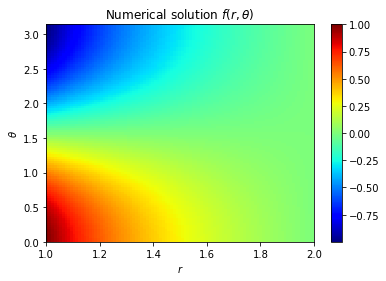

In [10]:
import numpy.polynomial.chebyshev as cheb

r = np.linspace(R1, R2, 100)
u = 2 * (r - (R1 + R2) / 2) / (R2 - R1)
theta = np.linspace(0, np.pi, 100)

r_grid, theta_grid = np.meshgrid(r, theta)
u_grid = 2 * (r_grid - (R1 + R2) / 2) / (R2 - R1)
f = np.zeros(r_grid.shape)

for l in range(L + 1):
    f = f + cheb.chebval(u_grid, fln[l, :]) * sph_harm(0, l, np.zeros(theta_grid.shape), theta_grid)

plt.figure()
# Becareful with pcolor function: ticks indicate bottom-left corners of grid cells
plt.pcolor(r_grid, theta_grid, np.real(f), cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('$r$')
plt.ylabel(r'$\theta$')
plt.title(r"Numerical solution $f(r, \theta)$")
plt.show()

**11)** Compare the previous numerical solution to the exact solution of this problem:
$$
    f(r, \theta) = (r/R_1)\frac{\left(R_1/r\right)^3 - a^3}{1-a^3}\cos (\theta) \text{ with } a = \frac{R_1}{R_2}
$$
We can try several values of $N$ or $L$ and observe the difference.

/home/bruno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


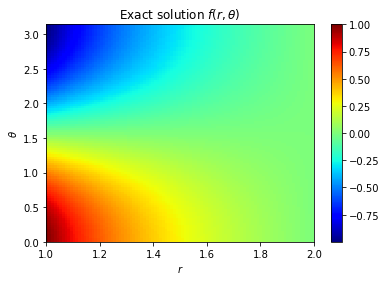

/home/bruno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/home/bruno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


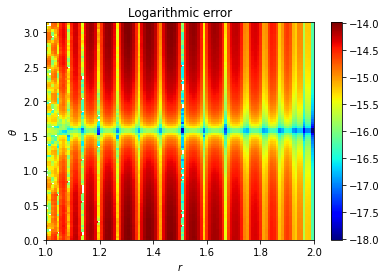

In [11]:
a = R1 / R2
f_exact = (r_grid / R1) * np.cos(theta_grid) * ((R1 / r_grid)**3  - a**3) / (1 - a**3)

plt.figure()
# Becareful with pcolor function: ticks indicate bottom-left corners of grid cells
plt.pcolor(r_grid, theta_grid, f_exact, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('$r$')
plt.ylabel(r'$\theta$')
plt.title(r"Exact solution $f(r, \theta)$")
plt.show()

plt.figure()
# Becareful with pcolor function: ticks indicate bottom-left corners of grid cells
plt.pcolor(r_grid, theta_grid, np.log10(np.abs(f_exact - np.real(f))), cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('$r$')
plt.ylabel(r'$\theta$')
plt.title("Logarithmic error")
plt.show()

**BONUS: 12)** We now want to check that our code is still working for boundary conditions involving multiple spherical harmonics. Numerically solve the same laplacian problem with:
$$
   \begin{cases}
        g_1 (\theta) = \exp\left(\cos\left(\theta\right)\right)\\
        g_2 (\theta) = 0
   \end{cases}
$$
We will then compare this numerical solution to the exact solution:
$$
    f(r,\theta) = \sum_{l=0}^{+\infty}(r/R_1)^l\frac{(R_1/r)^{2l+1}-a^{2l+1}}{1 - a^{2l+1}}g_lY_l^0(\theta)
$$
with $\{g_l\}$ the spherical harmonics coefficients of $g_1$, meaning $g_1(\theta)=\sum_{l=0}^{+\infty}g_lY_l^0(\theta)$.

/home/bruno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


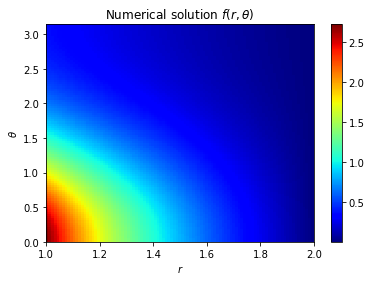

/home/bruno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


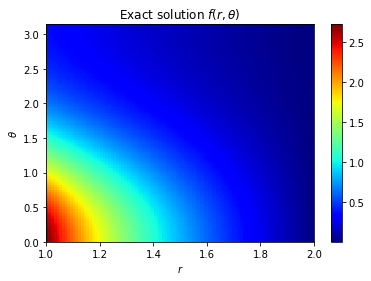

/home/bruno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log10
/home/bruno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


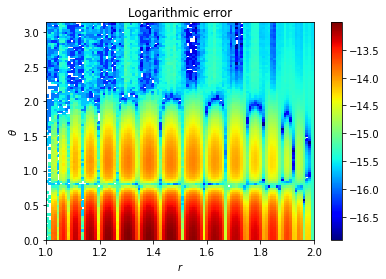

In [12]:
# Matrix builder

A = np.zeros((L + 1, N + 1, N + 1))
B = np.zeros((L + 1, N + 1))

A_tmp = M@M@D@D + 2*(R1 + R2)/(R2 - R1) * M@D@D + ((R1 + R2) / (R2 - R1))**2 * D@D + 2*M@D + 2*(R1 + R2)/(R2 - R1) * D
for l in range(L + 1):
    A[l, :, :] = A_tmp - l * (l + 1) * np.identity(N + 1)
    A[l, -1, :] = np.ones(N + 1)
    for j in range(N + 1):
        A[l, -2, j] = (-1) ** j
        # We only keep the real part of the projection but we should not in a general case!
        B[l, -2] = np.real(ylm_projection(lambda t, p: np.exp(np.cos(t)), l, 0))

# Solver
        
fln = np.zeros((L + 1, N + 1))

for l in range(L + 1):
    fln[l] = la.lu_solve(la.lu_factor(A[l]), B[l])
    
# Solution evalution

r = np.linspace(R1, R2, 100)
u = 2 * (r - (R1 + R2) / 2) / (R2 - R1)
theta  = np.linspace(0, np.pi, 100)

r_grid, theta_grid = np.meshgrid(r, theta)
u_grid = 2 * (r_grid - (R1 + R2) / 2) / (R2 - R1)
f = np.zeros(r_grid.shape)

for l in range(L + 1):
    f = f + cheb.chebval(u_grid, fln[l, :]) * sph_harm(0, l, np.zeros(theta_grid.shape), theta_grid)

# Plot of the solution
    
plt.figure()
# Becareful with pcolor function: ticks indicate bottom-left corners of grid cells
plt.pcolor(r_grid, theta_grid, np.real(f), cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('$r$')
plt.ylabel(r'$\theta$')
plt.title(r"Numerical solution $f(r, \theta)$")
plt.show()

# Comparison to the exact solution

a = R1 / R2
f_exact = np.zeros(r_grid.shape)
for l in range(L):
    f_exact += (r_grid / R1)**l * (((R1 / r_grid)**(2 * l + 1) - a**(2 * l + 1)) / (1 - a**(2 * l + 1))) \
        * np.real(ylm_projection(lambda t, p: np.exp(np.cos(t)), l, 0) * sph_harm(0, l, np.zeros(theta_grid.shape), theta_grid))

plt.figure()
# Becareful with pcolor function: ticks indicate bottom-left corners of grid cells
plt.pcolor(r_grid, theta_grid, f_exact, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('$r$')
plt.ylabel(r'$\theta$')
plt.title(r"Exact solution $f(r, \theta)$")
plt.show()

plt.figure()
# Becareful with pcolor function: ticks indicate bottom-left corners of grid cells
plt.pcolor(r_grid, theta_grid, np.log10(np.abs(f_exact - np.real(f))), cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('$r$')
plt.ylabel(r'$\theta$')
plt.title("Logarithmic error")
plt.show()